# 使用Pytorch实现简洁的线性回归

不知道大家上节课发给大家的Jupyter notebook有没有看一看最后的线性回归实现？  
如果看了，你肯定会想——这玩意怎么这么麻烦？不是说现在都是几行代码解决的嘛？  
所以我们就直接来实践一下如何使用Pytorch自带的许多方法，实现简洁的线性回归。  
这样的方法同样适用于别的各种网络，就算是复杂的ResNet或者BERT也一样。  

一个典型的网络训练过程包括以下几点：

1. 定义一个包含可训练参数的网络
2. 迭代整个输入
3. 通过网络处理输入
4. 计算损失(loss)
5. 反向传播梯度到网络的参数
6. 更新网络的参数

你会发现，实际上这六个步骤，Pytorch全部都有已经封装好的实现！

1. 使用`nn.Module`定义一个网络
2. 使用`Dataset`和`Dataloader`迭代输入
3. 使用网络的`forward`函数定义数据的前向传播
4. `nn`模块自带了一系列loss函数
5. 对loss值使用`backward`进行反向传播
6. 使用`nn.optim`定义一个优化器并更新网络参数

假设房价$p$受面积$x_1$和房龄$x_2$的影响——  
$$p = x_1w_1+x_2w_2+b$$  
其中$w1$，$w2$是面积和房龄对应的权重(weight)，$b$是偏移值(bias)。

我们通常收集一系列的真实数据，例如多栋房屋的真实售出价格和它们对应的面积和房龄。我们希望在这个数据上面，寻找模型参数来使模型的预测价格与真实价格的误差最小。在机器学习术语里，该数据集被称为训练数据集（training data set）或训练集（training set），一栋房屋被称为一个样本（sample），其真实售出价格叫作标签（label），用来预测标签的两个因素叫作特征（feature）。我们希望用特征用来表征样本的特点。

在模型训练中，我们需要衡量价格预测值与真实值之间的误差。  
通常我们会选取一个非负数作为误差，且数值越小表示误差越小。一个常用的选择是平方函数——
$$L(w1,w2,b)=\frac{1}{2}(\hat{y}-y)^2$$

我们要做的就是选择合适的$w1$，$w2$，$b$，使得损失函数$L$的值最小。总体的损失函数可以从单个样本的损失函数求平均得来。
$$L(w1,w2,b)=\frac{1}{n} \sum_{i=1}^n L^i $$

## 数据准备
由于我们现在没有实际的真实数据，我们就来随便生成一堆数据。  

In [1]:
import torch
from matplotlib import pyplot as plt
from IPython import display
import numpy as np
import random

In [2]:
# 我们来随机生成一堆数据
num_inputs = 2
num_examples = 1024
true_w = [5, -2]
true_b = 3
features = torch.rand(num_examples, num_inputs, dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
# 加入一点噪声/扰动
labels += torch.rand_like(labels)/10
# labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float32)

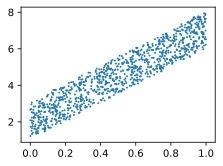

In [3]:
# 用矢量图显示
display.set_matplotlib_formats('svg')
# 设置图的大小
plt.rcParams['figure.figsize'] = (3.5, 2.5)
# 看看“面积”和“价格”的关系
plt.scatter(features[:, 0].numpy(), labels.numpy(), 1);

Pytorch提供了data包来读取数据。我们目前用到的是其中的两个类，`Dataset`和`DataLoader`。  
利用这两个类将数据载入到模型的操作顺序是这样的：
1. 创建一个`Dataset`对象，这个`Dataset`包含了features和对应的label；
2. 创建一个`DataLoader`对象，这个`DataLoader`会从Dataset中按照设置取数据；
3. 迭代这个`DataLoader`对象，将features和对应的label加载到模型中进行训练；

要注意的是，`Dataset`类只接受“规范”的数据，也就是每个样本的维度必须一致。  
features[0] = [233, 777, 123]  
label[0] = [7]  
features[1] = [145, 220]     
label[1] = [6]  
这样子的数据集使用Dataset会报错。  

Dataset可以接受多个Tensor，只要它们的第一个维度（数据的样本个数）相同就行。  
举个我在自己代码里使用的例子：
```
data = TensorDataset(input_ids, input_mask, segment_ids, label_ids)
```

In [4]:
# 首先导入这两个类
from torch.utils.data import TensorDataset, DataLoader
# 首先生成Dataset
dataset = TensorDataset(features, labels)
# 在每一次迭代中，随机读取包含16个数据样本的小数据集，这个数字一般称为batch size
batch_size=16
# 使用DataLoader迭代获取数据，设置上batch_size为16，shuffle=True会打乱数据集
dataloader = DataLoader(dataset, batch_size, shuffle=True)

## 定义网络
大家如果去看上一个notebook最后的线性回归，会发现代码相当繁琐，当中任何一个错误就会让网络跑不起来/结果错误。  
但是实际上Pytorch提供了大量预定义的层，这也就是为啥好多广告里都会写“十行代码搞定nn”这样子。我们只需要使用已经封装好的层，像搭积木一样，搭出你需要的模型即可。我们还是从线性回归开始说起。

Pytorch中的网络类基本都在`torch.nn`包中。“nn”是neural networks（神经网络）的缩写。这个包里封装好了大量常用的神经网络层，并且也配置好了autograd。

nn的核心数据结构是Module，它是一个比较宽泛的类，既可以表示神经网络中的某个层（layer），也可以表示一个包含很多层的神经网络。在实际使用中，最常见的做法是继承nn.Module，撰写自己的网络/层。一个nn.Module实例应该包含一些层以及返回输出的前向传播（forward）方法。Pytorch会自动实现反向传播算法。下面先来看看如何用nn.Module实现一个线性回归模型。

In [5]:
from torch import nn
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, 1)
    # forward 定义前向传播
    def forward(self, x):
        y = self.linear(x)
        # y_hat
        return y

# 初始化网络的实例
# num_inputs = 2
net = LinearNet(num_inputs)
# 使用print可以打印出网络的结构
print(net)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


如果你在做一个简单的网络（没有旁路结构），也可以使用`nn.Sequential`来搭建网络。
要注意的是`nn.Sequential`的初始化函数是没有异常检查的，因此最好检查一下自己的代码~

In [6]:
# 写法一
net = nn.Sequential(
    nn.Linear(num_inputs, 1)
    # 此处还可以传入其他层
)

# 写法二
net = nn.Sequential()
net.add_module('linear', nn.Linear(num_inputs, 1))
# net.add_module ......

# 写法三
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
          ('linear', nn.Linear(num_inputs, 1))
          # ......
        ]))

print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


模型中所有可训练的参数可以用`net.parameters()`来获得：

In [7]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[0.0490, 0.3285]], requires_grad=True)
Parameter containing:
tensor([0.1559], requires_grad=True)


## 初始化参数
实际上，初始化的时候Pytorch已经自动帮你初始化好了参数，并且初始化方法好多都是论文验证过的，有效的方法。关于每种层的参数如何初始化的，可以去看它的源码，比如说`Linear`的初始化如下。
```
def reset_parameters(self):
    init.kaiming_uniform_(self.weight, a=math.sqrt(5))
    if self.bias is not None:
        fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
        bound = 1 / math.sqrt(fan_in)
        init.uniform_(self.bias, -bound, bound)
```
可以看到，`weight`使用的是`kaiming_uniform_`方法进行初始化，这是一种称为Kaiming初始化的方法，在使用Relu激活函数的时候比较有效，有兴趣的可以去看论文：
https://arxiv.org/abs/1502.01852

如果你有强迫症，或者有什么特殊需求（比如说你想证明你的初始化方法更好，发一篇顶会），可以使用init包里的一些函数：

In [8]:
from torch.nn import init

init.normal_(net[0].weight, mean=0, std=0.01)
# 也可以直接修改bias的data: net[0].bias.data.fill_(0)
init.constant_(net[0].bias, val=0)

Parameter containing:
tensor([0.], requires_grad=True)

要注意的是，只有通过`nn.Sequential`或者`nn.ModuleList`（可以理解为没有forward方法的`nn.Sequential`）方法生成的网络可以用上面这种`net[0]`的方法来访问其中的一层。如果你使用的是继承`nn.Module`（代码块5里）的方法来生成网络，因为我们是用`self.linear = nn.Linear(n_feature, 1)`来生成这一层的，那上面的代码应该改成：
```
init.normal_(net.linear.weight, mean=0, std=0.01)
init.constant_(net.linear.bias, val=0)
```

## 定义损失函数
PyTorch在nn模块中提供了各种损失函数，这些损失函数可看作是一种特殊的层，PyTorch也将这些损失函数实现为nn.Module的子类。我们现在使用它提供的均方误差损失作为模型的损失函数。

In [9]:
loss = nn.MSELoss()

## 定义优化器
torch.optim模块提供了很多常用的优化算法比如SGD、Adam和RMSProp等。有机会也会给大家讲讲不同的优化器。  
![avatar](素材/不同的优化器.gif)

我们这里就用最简单的SGD即可。

In [10]:
import torch.optim as optim
# 定义一个SGD优化器，需要优化的参数为net中的所有parameters，学习率（learning rate，lr）设为0.1
optimizer = optim.SGD(net.parameters(), lr=0.1)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0
    nesterov: False
    weight_decay: 0
)


优化器也有许多可以自定义的参数，但我们暂时不涉及到fine-tune之类的方法，在fine-tune时，一般已经训练好的网络的lr比较小，而自己新加的网络的lr需要比较大。  
顺便解释一下上面的这5个参数：
1. dampening 动量的惩罚因子
2. lr 学习率
3. momentum 动量因子
4. nesterov 使用Nesterov动量（NAG）
5. weight_decay 在SGD中等价于使用L2权重衰减，但在一些别的优化器中不等价

SGD里可以调整的参数就是这些。我们一般来说最关注的就是lr，这个参数直接决定了我们的网络的效果。如果你的网络收敛速度过慢也可以考虑使用momentum。

此外，我们希望模型前面能学的稍微快一点，后面则更加精细；虽然优化器已经做了大部分工作，但是我们也可以使用学习率衰减来加速这个过程。目前很多大模型都会用到学习率衰减。

In [11]:
# 调整学习率
for param_group in optimizer.param_groups:
    param_group['lr'] *= 0.1 # 学习率为之前的0.1倍
    param_group['lr'] *= 10 # 再改回来

## 开始训练
折腾了这么久，终于可以开始训练了！感受一下9行代码跑nn的感觉吧~

In [12]:
# 我们希望把整个数据集跑多少遍，称为epoch
num_epochs = 3
for epoch in range(num_epochs):
    # 从dataloader中一个batch一个batch地读数据
    for X, y in dataloader:
        output = net(X)
        # y.shape=16 -> y.shape=(16, 1)
        l = loss(output, y.view(-1, 1))
        # print(l)
        optimizer.zero_grad() # 梯度清零，等价于net.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch + 1, l.item()))

epoch 1, loss: 0.194741
epoch 2, loss: 0.021741
epoch 3, loss: 0.004183


这段代码里有几个要说的：
1. 为啥是`net(X)`而不是`net.forward(X)`？其实两个都可以，第一种方法调用的是`net`的`__call__`方法，而这个方法在`nn.Module`中有实现，会调用`forward`方法。
2. 先做梯度清零，再从Loss值开始做反向传播；
3. `optimizer.step()`做的就是更新参数的操作；
4. Pytorch的loss不接受一维的数据，必须是二维的，所以我们这里需要用view或者unsqueeze来扩展出第二个维度。

最后来看看结果如何？

In [13]:
dense = net[0]
print(true_w)
print(dense.weight)
print(true_b)
print(dense.bias)

[5, -2]
Parameter containing:
tensor([[ 4.9192, -1.8616]], requires_grad=True)
3
Parameter containing:
tensor([3.0182], requires_grad=True)


如果不是初始化很奇怪/lr设的太高或太低，并且生成的数据不要那么奇葩外，loss这时候应该已经相当低了，我们预测的值也会和真实值相差不大。